```
Author  - Sreejith S
U4A3    - Neural Networks- Titanic
Dataset - https://www.kaggle.com/c/titanic/data
```

In [123]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.utils import np_utils

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

%reload_ext autoreload
%matplotlib inline
%autoreload 2
%config InlineBackend.figure_format = 'retina'

#set pd display options
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 80)

In [124]:
print(tf.__version__)

2.3.0


## Read about the titanic dataset - [\[link\]](https://www.kaggle.com/c/titanic/data).

Try to understand the features, the type of features (continuous values, categorical) and the target variable. Download the train.csv and test.csv files. Try to plot each of the features and its influence on the target variable. You can use python or spreadsheet to make the plots. Make your interpretations and try to answer the following questions using the relevant plots.



In [125]:
df_train = pd.read_csv("../datasets/titanic/train.csv")
df_train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

**Feature Engineering**

[Link](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)

We'll select a few feature engineering techniques from above link as well.

In [126]:
#Turning cabin number into Deck
def get_deck(x, cabin_list):
    try:
        return x[0]
    except TypeError:
        return 'U'

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
df_train['Deck'] = df_train['Cabin'].map(lambda x: get_deck(x, cabin_list))
df_test['Deck'] = df_test['Cabin'].map(lambda x: get_deck(x, cabin_list))

#Creating new family_size column
df_train['Family_Size'] = df_train['SibSp']+df_train['Parch']
df_test['Family_Size'] = df_test['SibSp']+df_test['Parch']

#Fix NaN
df_train.fillna(df_train.mean(), inplace=True)


#Make continous data to categorical - only for plotting
#Divide Age into 10 bins 
df_train['Age_Range'] = pd.qcut(df_train['Age'], 10, duplicates='drop') 
#Divide Age into 5 bins 
df_train['Fare_Range'] = pd.qcut(df_train['Fare'], 5) 


def cat_plotter(x, hue, df_train, height=5, width=12.5):
    axs = sns.catplot(x=x, hue=hue, kind ="count", data=df_train, height=5, aspect=width/height)
    bars = axs.ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]
    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r
        axs.ax.annotate(format(height_l/total, '.2f'), 
                        (left.get_x() + left.get_width() / 2., height_l + 1),
                        ha = 'center', va = 'center', xytext = (0, 10),
                        textcoords = 'offset points')
    plt.show()

In [127]:
df_train = df_train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
#df_test = df_test.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

### [1 MARK] Which features, in your interpretation, would be good predictors for the survival rate in titanic?

Let's start by looking at the correlation between numerical data. `pandas.DataFrame.corr()` can be used to investigate linear relations between columns, but there might be non-linear relationships too. One thing that is evident from the correlation matrix is that `Pclass` has a strong linear relation with `Survived`.

`Pclass`, `Sex`, `SibSp`, `Parch`, `Family_Size`, `Fare`, `Age`, `Embarked`, `Cabin` (Considering Deck) would be good indicators for the survival rate in the Titanic. 
Passengers travelling in first class, and those paying higher fares had lower mortality rate that others. 
While mortality rate for men was `80%`, that of women was `26%`. Having no family members onboard or having too many family members reduced the chance of survival.

Those with no cabins (third class passengers) had the highest mortality rates. After extracting `Deck` from `Cabin` data, it can be observed that some decks had better survival rates.

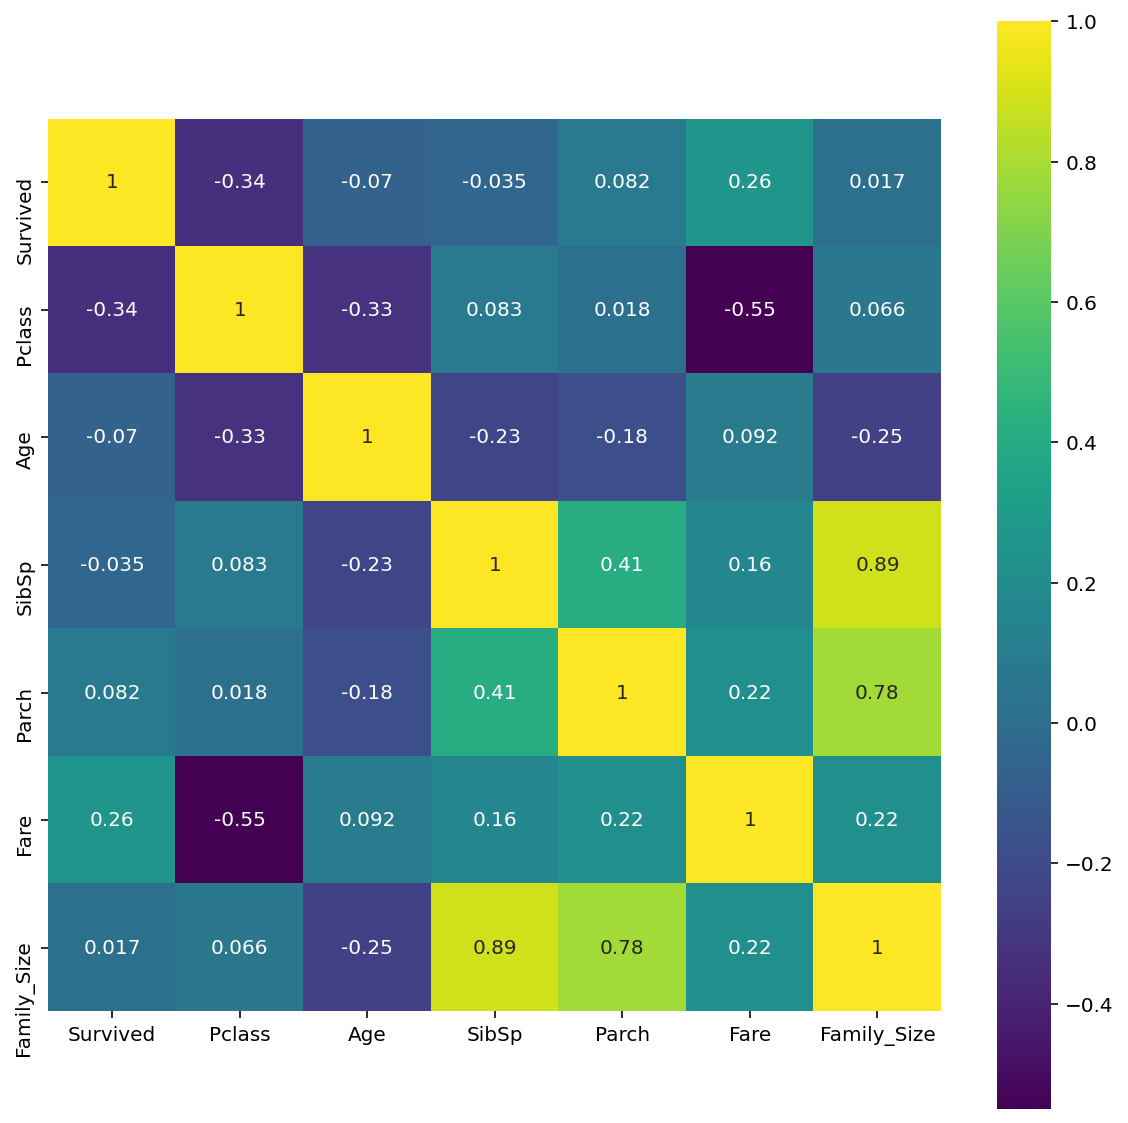

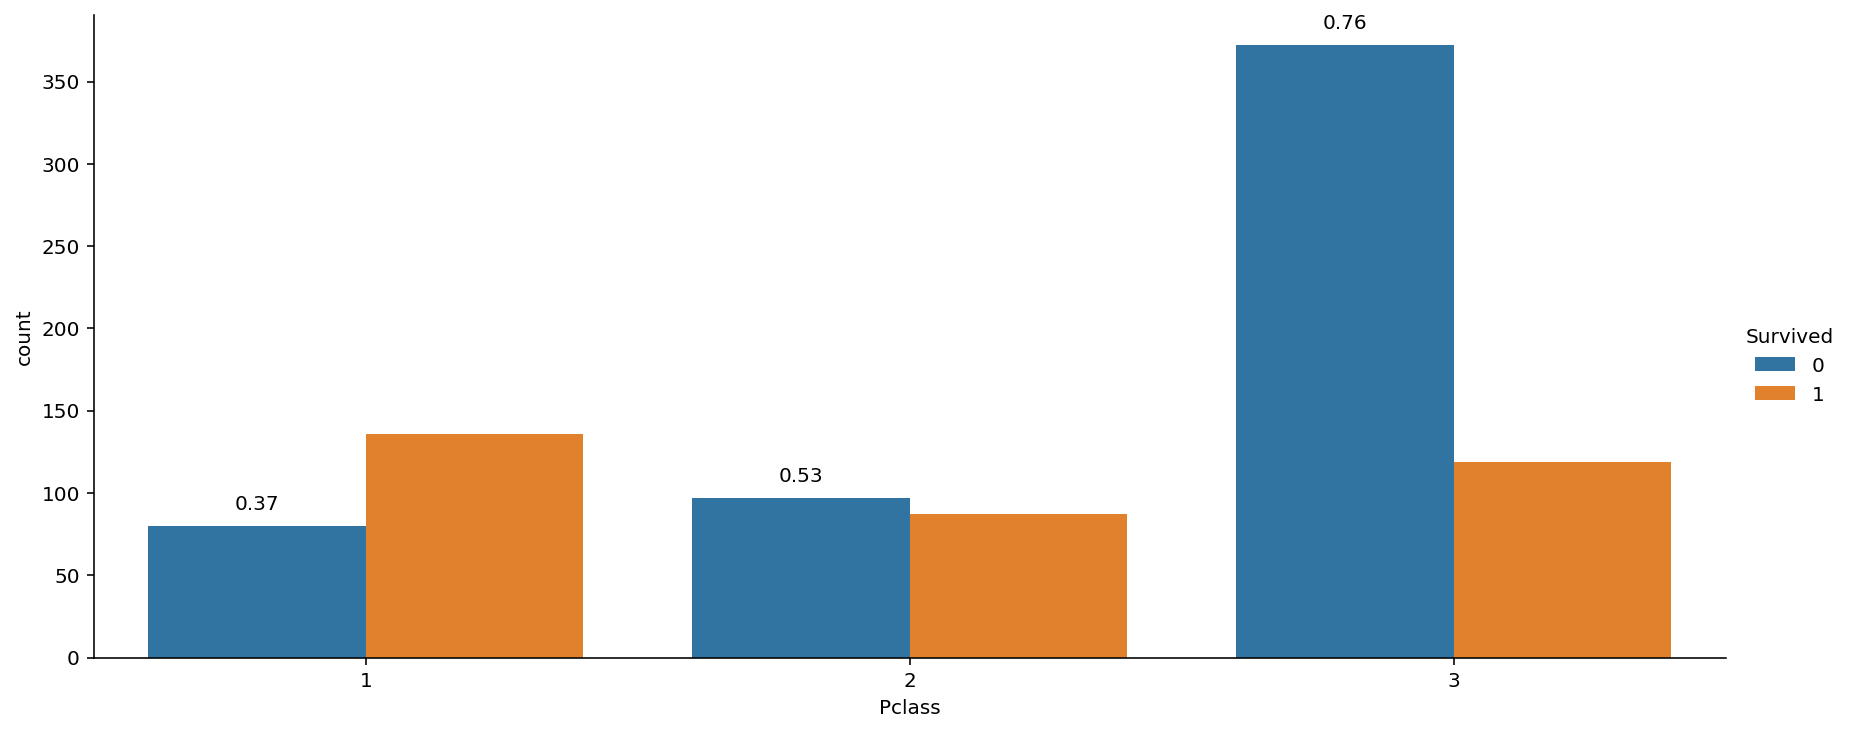

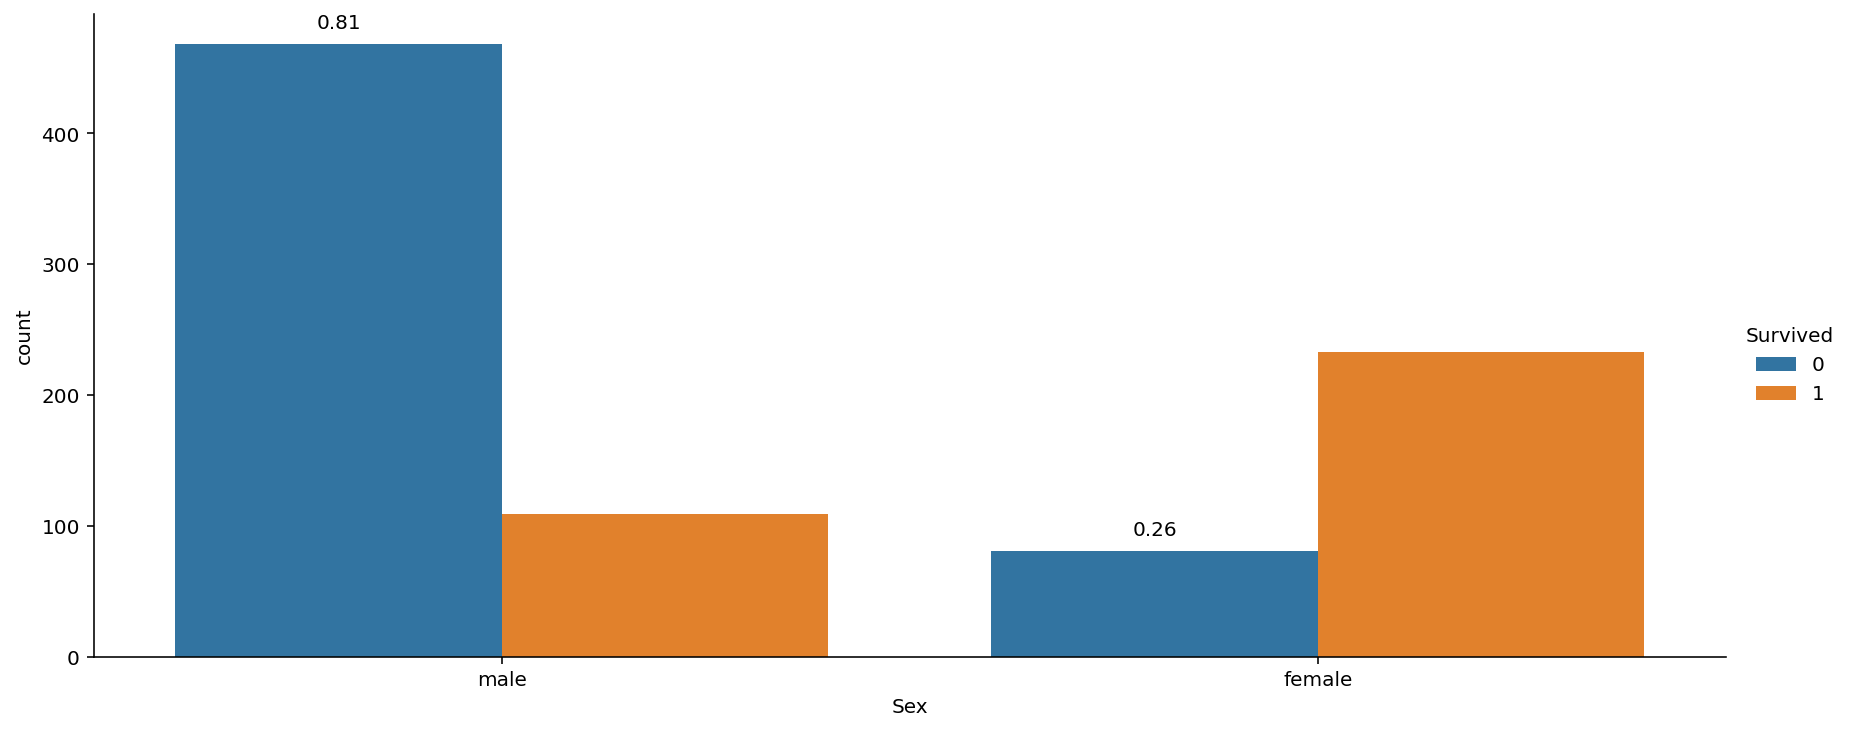

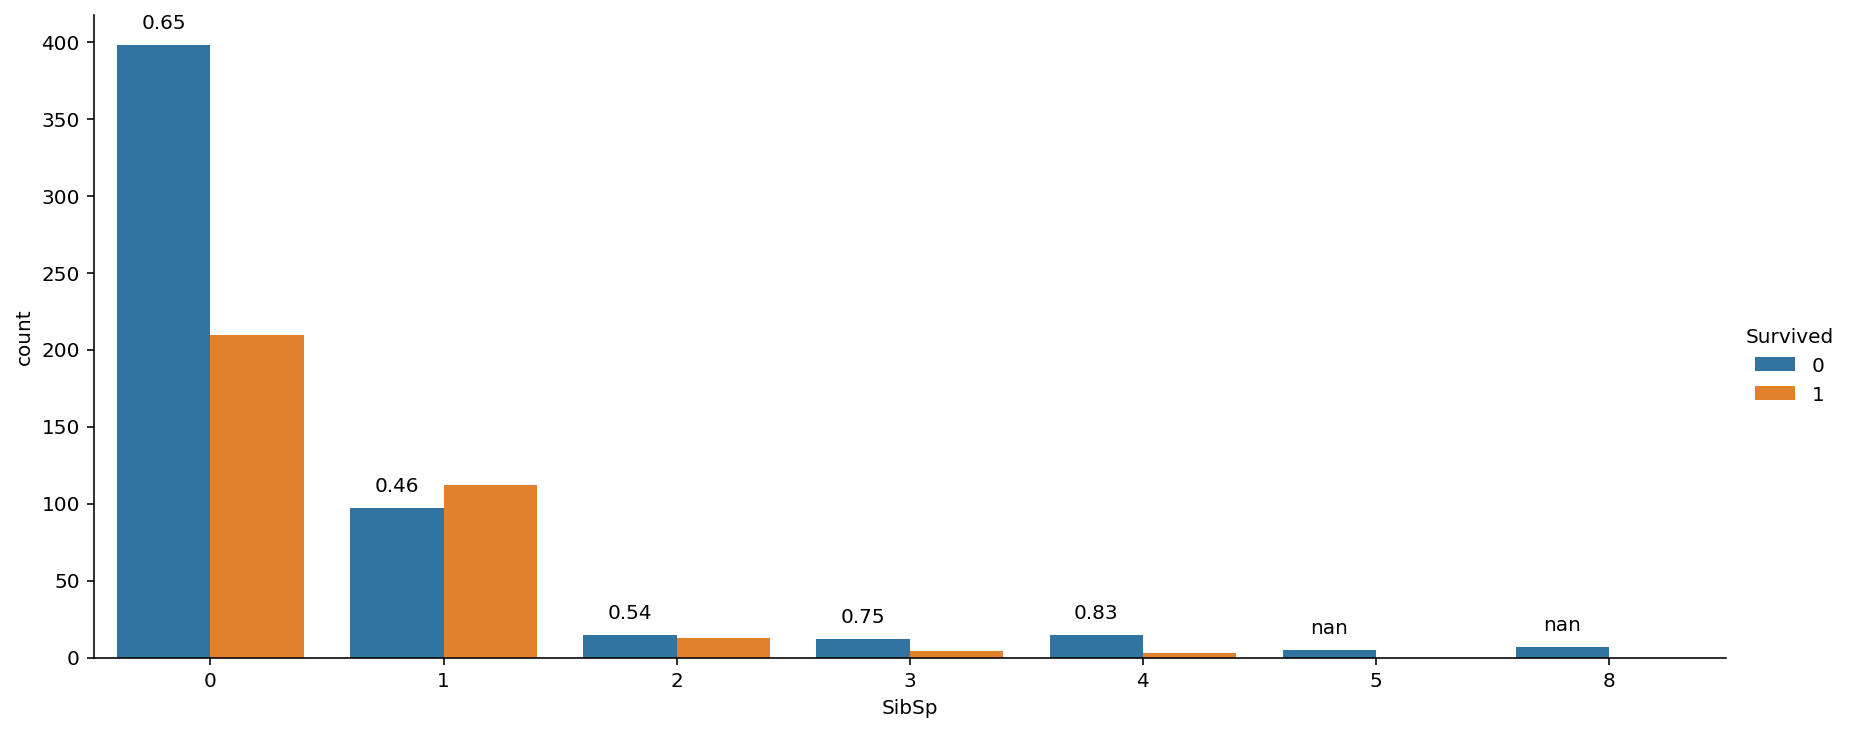

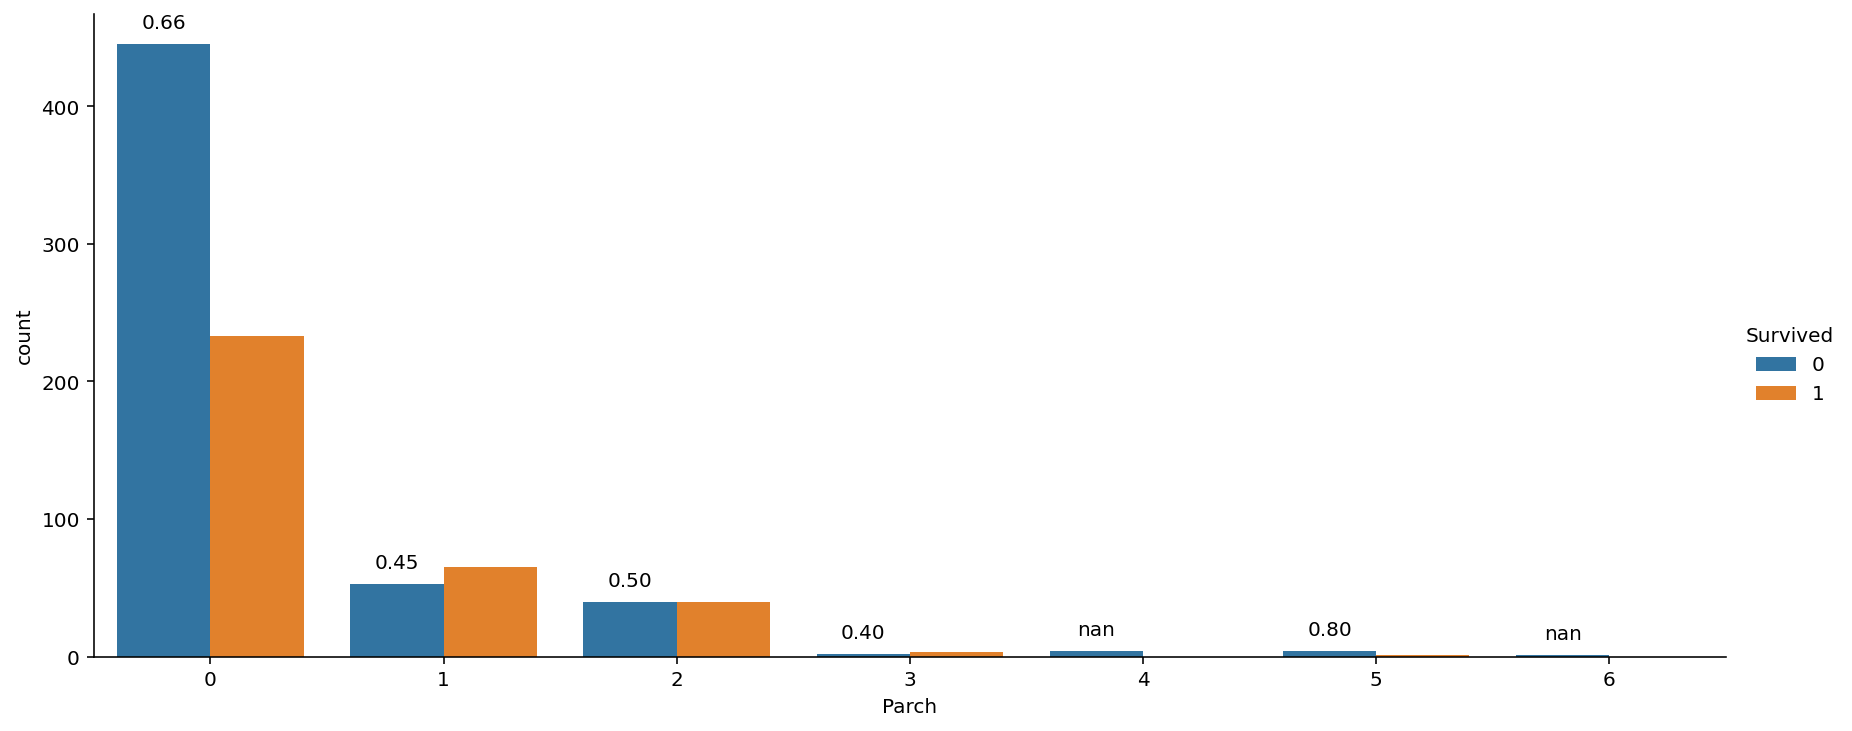

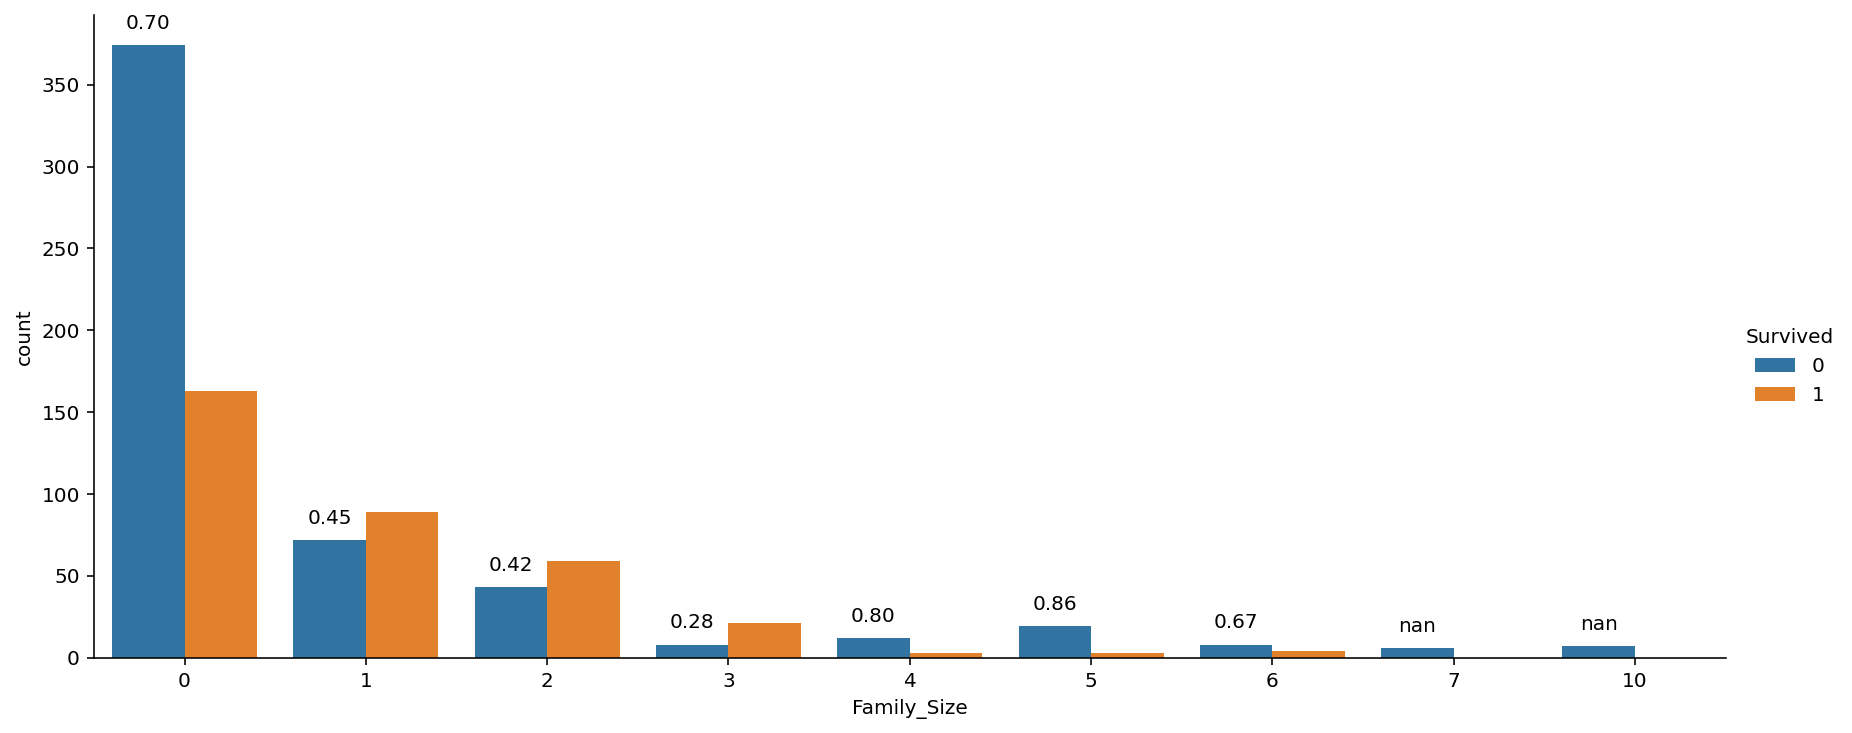

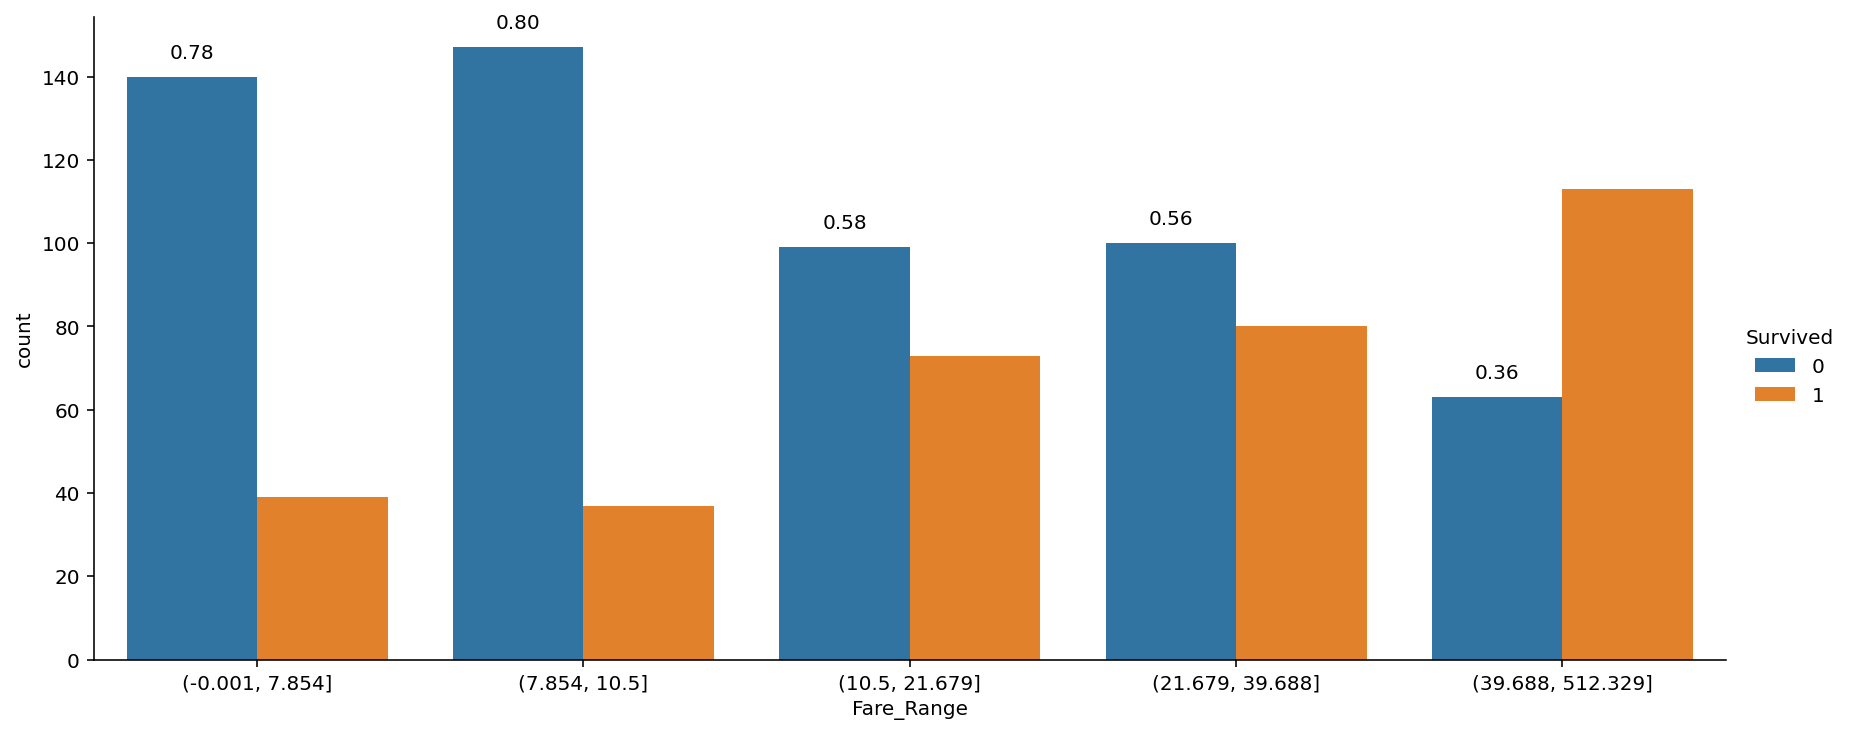

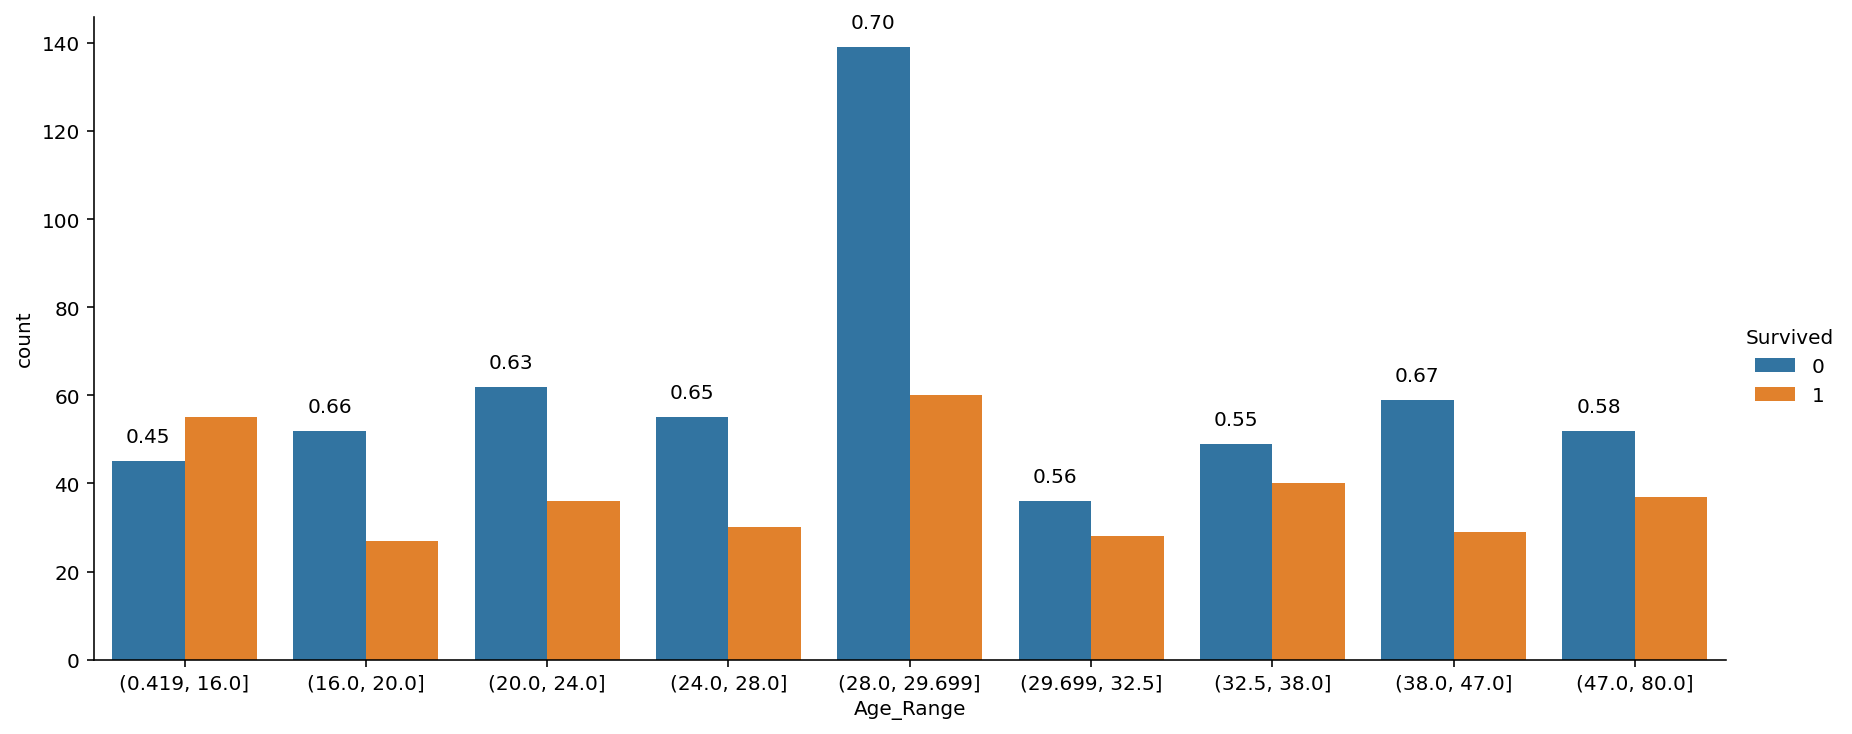

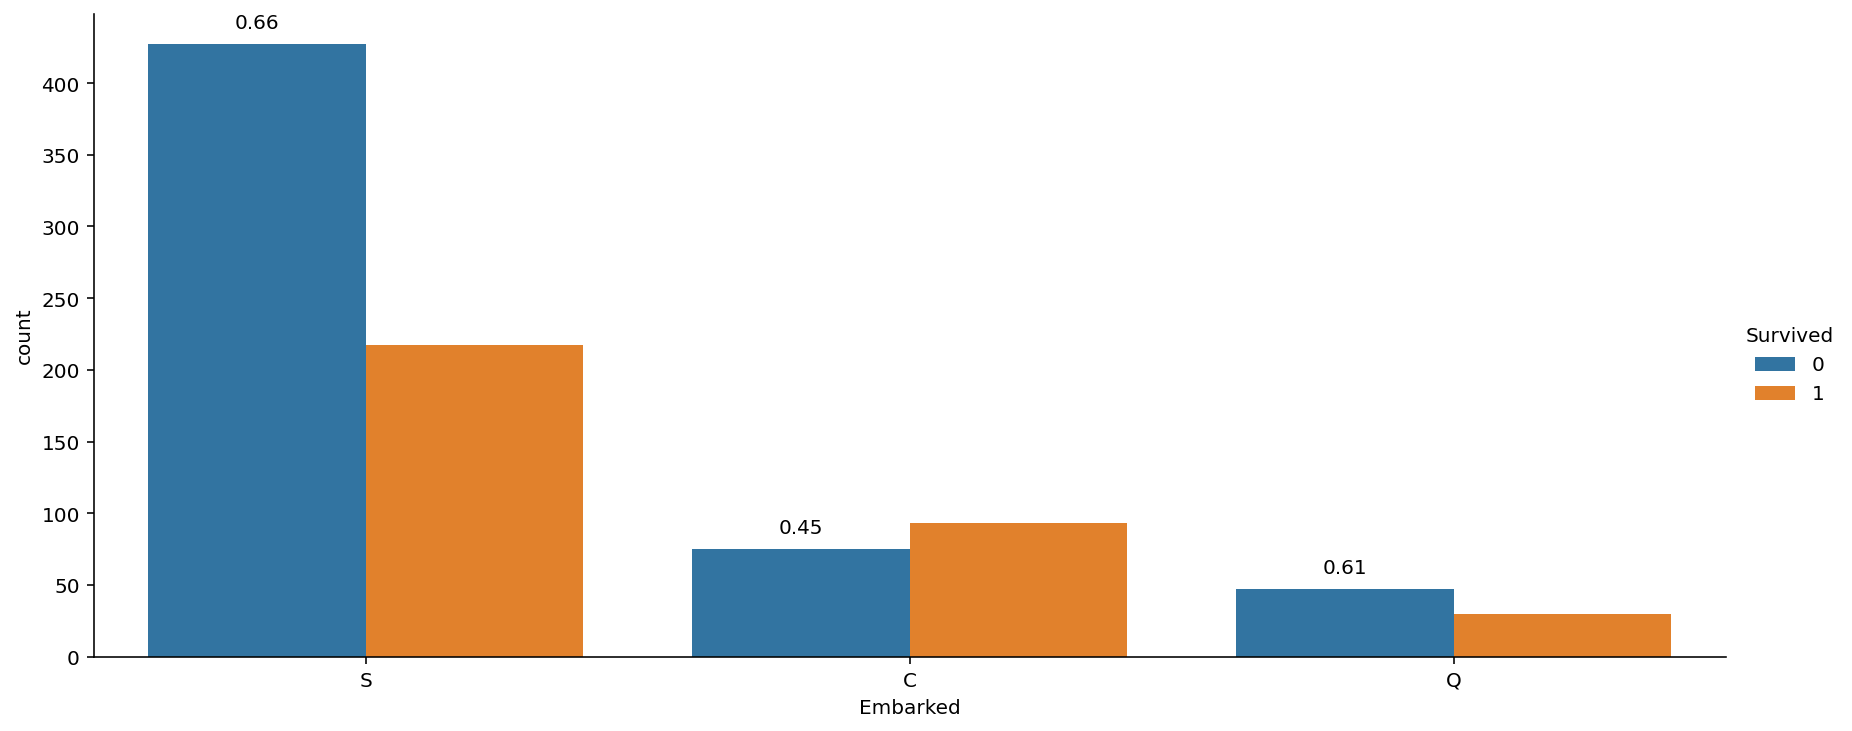

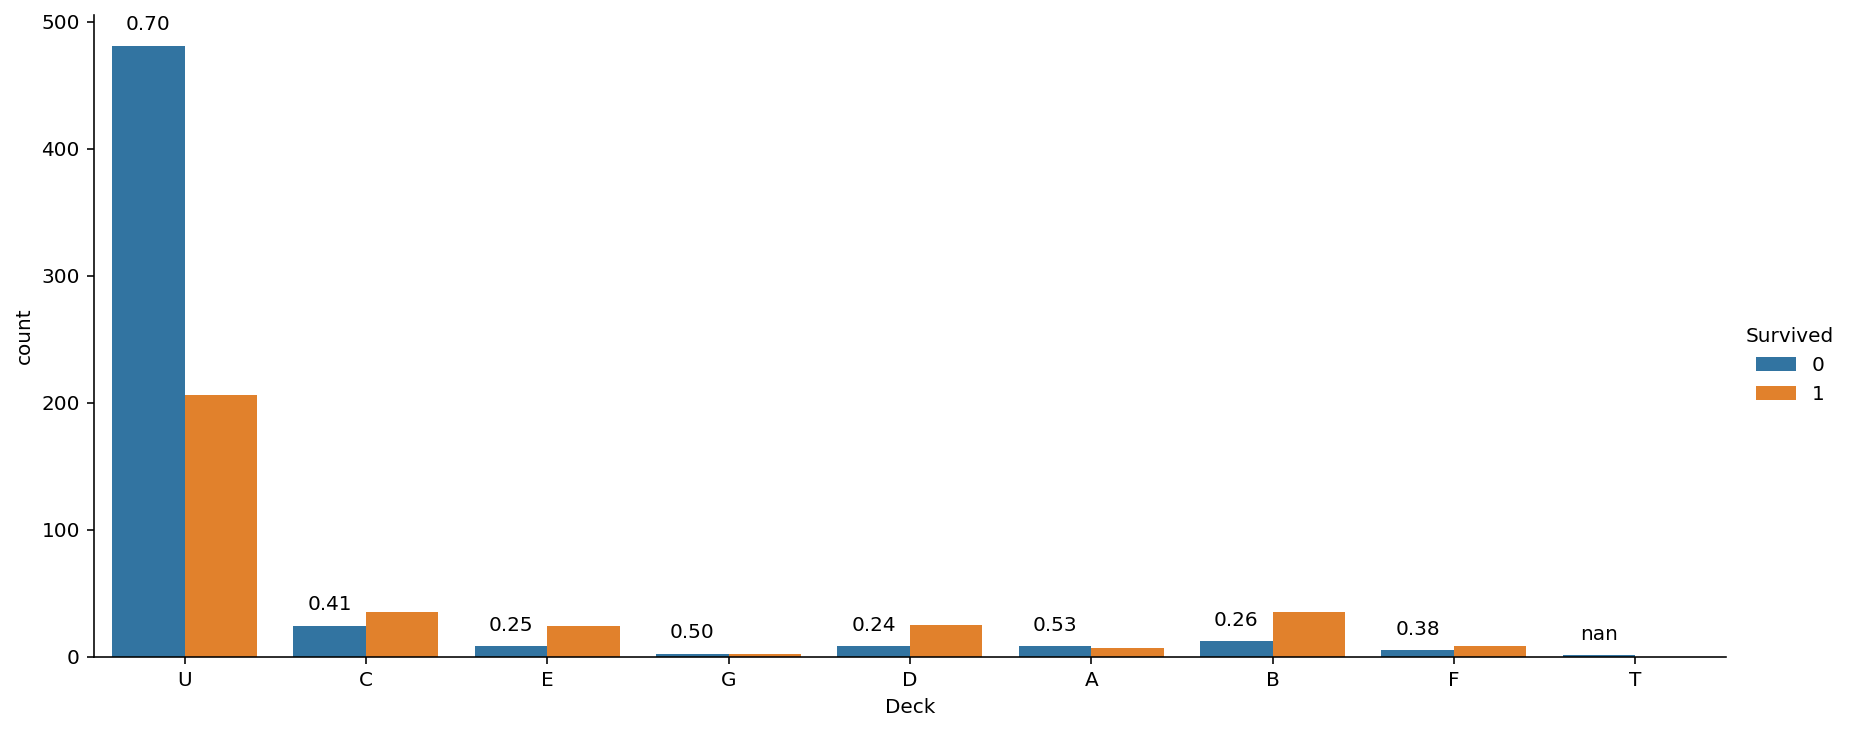

In [128]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr() ,square = True, cmap='viridis'
           ,annot=True, fmt='.2g'
           )
plt.show()

cols = ["Pclass", "Sex", "SibSp", "Parch", "Family_Size", "Fare_Range", "Age_Range", "Embarked", "Deck"]  

for c in cols:
    cat_plotter(c, "Survived", df_train,  height=5, width=12)

#df_train.drop(columns=["Age_Range", "Fare_Range"])

X_train = df_train.drop(columns=["Survived", "Age_Range", "Fare_Range"])
y_train = df_train["Survived"]

### [1 MARK] Which features, in your interpretation, are not good predictors?

`PassengerId`, `Name` and `Ticket` can be dropped as they wouldn't be good indicators. Even though, surnames can be extracted from `Name` which might be an indicator of of social status and gender. Further exploration has to be done in order to understand whether `Name` and `Ticket` are good predictors. As of now we can ignore them.

### What is the size of the train dataset and test dataset?

In [129]:
print("len(train) = ", len(df_train))
print("len(test) = ", len(df_test))

len(train) =  891
len(test) =  418


### [1 MARK] Would you standardize or normalize the input features, or just use the raw features, or try out all different ways and then decide based on final performance evaluation?

The features have different ranges, this means stadardizing or normalizing might help. 

## Create a new colab/jupyter notebook and build a multi-layer perceptron (ANN) model
Predict the target variable using (a) all the features (b) only the features that you think are good predictors. You could try to standardize or normalize the features based on your answer to (11.1.4). Report the performance evaluation of these models using standard evaluation metrics for classification problems. Answer the following questions by writing down the answers as well as putting down the screenshots that are relevant to the answer.


In [130]:
# std or normalize
numericals = list(X_train.select_dtypes(include=['int64', 'float64', 'int32']).columns) #list of numerical dataseries
scaler_fit = StandardScaler().fit(X_train[numericals])
X_train_scaled = pd.DataFrame(data=X_train) #create a copy
# df_test_scaled = pd.DataFrame(data=df_test)
X_train_scaled[numericals] = scaler_fit.transform(X_train_scaled[numericals])
# df_test_scaled[numericals] = scaler_fit.transform(df_test_scaled[numericals])


# One-hot encoding
for i in list(X_train.select_dtypes(include=['object']).columns):
    X_train_scaled = pd.concat([X_train_scaled, pd.get_dummies(X_train_scaled[i], prefix=i)],axis=1)
    X_train_scaled.drop(i, axis = 1, inplace=True)

X_train_scaled.head(5)

Pclass       Age     SibSp     Parch      Fare  Family_Size  Sex_female  \
0  0.827377 -0.592481  0.432793 -0.473674 -0.502445     0.059160           0   
1 -1.566107  0.638789  0.432793 -0.473674  0.786845     0.059160           1   
2  0.827377 -0.284663 -0.474545 -0.473674 -0.488854    -0.560975           1   
3 -1.566107  0.407926  0.432793 -0.473674  0.420730     0.059160           1   
4  0.827377  0.407926 -0.474545 -0.473674 -0.486337    -0.560975           0   

   ...  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Deck_U  
0  ...       0       0       0       0       0       0       1  
1  ...       1       0       0       0       0       0       0  
2  ...       0       0       0       0       0       0       1  
3  ...       1       0       0       0       0       0       0  
4  ...       0       0       0       0       0       0       1  

[5 rows x 20 columns]

In [133]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(20,)),
        tf.keras.layers.Dense(20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(100, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(100, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

X_train_all = X_train_scaled.to_numpy()
X_train_best = X_train_scaled.drop(columns=["SibSp", "Parch", "Family_Size"]).to_numpy()

y_train_ = np_utils.to_categorical(y_train, 2) #classes = 2

history = model.fit(X_train_all, y_train_, batch_size=700, epochs=200,
                   verbose=2, validation_split=0.2)

Epoch 1/200
2/2 - 0s - loss: 0.6981 - binary_accuracy: 0.4761 - val_loss: 0.6337 - val_binary_accuracy: 0.6480
Epoch 2/200
2/2 - 0s - loss: 0.6467 - binary_accuracy: 0.6166 - val_loss: 0.5989 - val_binary_accuracy: 0.6592
Epoch 3/200
2/2 - 0s - loss: 0.6276 - binary_accuracy: 0.6320 - val_loss: 0.5786 - val_binary_accuracy: 0.7709
Epoch 4/200
2/2 - 0s - loss: 0.6170 - binary_accuracy: 0.6756 - val_loss: 0.5650 - val_binary_accuracy: 0.7877
Epoch 5/200
2/2 - 0s - loss: 0.6054 - binary_accuracy: 0.7346 - val_loss: 0.5486 - val_binary_accuracy: 0.7933
Epoch 6/200
2/2 - 0s - loss: 0.5919 - binary_accuracy: 0.7402 - val_loss: 0.5267 - val_binary_accuracy: 0.7989
Epoch 7/200
2/2 - 0s - loss: 0.5818 - binary_accuracy: 0.7346 - val_loss: 0.5037 - val_binary_accuracy: 0.7989
Epoch 8/200
2/2 - 0s - loss: 0.5561 - binary_accuracy: 0.7472 - val_loss: 0.4884 - val_binary_accuracy: 0.8101
Epoch 9/200
2/2 - 0s - loss: 0.5481 - binary_accuracy: 0.7486 - val_loss: 0.4741 - val_binary_accuracy: 0.8101
E

Epoch 75/200
2/2 - 0s - loss: 0.4274 - binary_accuracy: 0.8076 - val_loss: 0.3618 - val_binary_accuracy: 0.8659
Epoch 76/200
2/2 - 0s - loss: 0.4344 - binary_accuracy: 0.8230 - val_loss: 0.3635 - val_binary_accuracy: 0.8771
Epoch 77/200
2/2 - 0s - loss: 0.4355 - binary_accuracy: 0.8118 - val_loss: 0.3631 - val_binary_accuracy: 0.8771
Epoch 78/200
2/2 - 0s - loss: 0.4223 - binary_accuracy: 0.8272 - val_loss: 0.3628 - val_binary_accuracy: 0.8827
Epoch 79/200
2/2 - 0s - loss: 0.4271 - binary_accuracy: 0.8202 - val_loss: 0.3660 - val_binary_accuracy: 0.8827
Epoch 80/200
2/2 - 0s - loss: 0.4307 - binary_accuracy: 0.8118 - val_loss: 0.3693 - val_binary_accuracy: 0.8771
Epoch 81/200
2/2 - 0s - loss: 0.4315 - binary_accuracy: 0.8104 - val_loss: 0.3701 - val_binary_accuracy: 0.8659
Epoch 82/200
2/2 - 0s - loss: 0.4279 - binary_accuracy: 0.8188 - val_loss: 0.3711 - val_binary_accuracy: 0.8547
Epoch 83/200
2/2 - 0s - loss: 0.4451 - binary_accuracy: 0.8090 - val_loss: 0.3718 - val_binary_accuracy:

Epoch 148/200
2/2 - 0s - loss: 0.4118 - binary_accuracy: 0.8188 - val_loss: 0.3544 - val_binary_accuracy: 0.8659
Epoch 149/200
2/2 - 0s - loss: 0.4151 - binary_accuracy: 0.8315 - val_loss: 0.3532 - val_binary_accuracy: 0.8659
Epoch 150/200
2/2 - 0s - loss: 0.4258 - binary_accuracy: 0.8160 - val_loss: 0.3516 - val_binary_accuracy: 0.8659
Epoch 151/200
2/2 - 0s - loss: 0.4172 - binary_accuracy: 0.8272 - val_loss: 0.3478 - val_binary_accuracy: 0.8659
Epoch 152/200
2/2 - 0s - loss: 0.4096 - binary_accuracy: 0.8301 - val_loss: 0.3435 - val_binary_accuracy: 0.8827
Epoch 153/200
2/2 - 0s - loss: 0.4102 - binary_accuracy: 0.8244 - val_loss: 0.3472 - val_binary_accuracy: 0.8883
Epoch 154/200
2/2 - 0s - loss: 0.4074 - binary_accuracy: 0.8272 - val_loss: 0.3593 - val_binary_accuracy: 0.8771
Epoch 155/200
2/2 - 0s - loss: 0.4043 - binary_accuracy: 0.8301 - val_loss: 0.3703 - val_binary_accuracy: 0.8827
Epoch 156/200
2/2 - 0s - loss: 0.4177 - binary_accuracy: 0.8216 - val_loss: 0.3792 - val_binary_

In [135]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(17,)),
        tf.keras.layers.Dense(20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(100, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(100, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

X_train_best = X_train_scaled.drop(columns=["SibSp", "Parch", "Family_Size"]).to_numpy()

y_train_ = np_utils.to_categorical(y_train, 2) #classes = 2

history = model.fit(X_train_best, y_train_, batch_size=700, epochs=200,
                   verbose=2, validation_split=0.2)

Epoch 1/200
2/2 - 0s - loss: 0.7049 - binary_accuracy: 0.4017 - val_loss: 0.6521 - val_binary_accuracy: 0.6983
Epoch 2/200
2/2 - 0s - loss: 0.6595 - binary_accuracy: 0.6994 - val_loss: 0.6292 - val_binary_accuracy: 0.6816
Epoch 3/200
2/2 - 0s - loss: 0.6434 - binary_accuracy: 0.6517 - val_loss: 0.6104 - val_binary_accuracy: 0.6927
Epoch 4/200
2/2 - 0s - loss: 0.6299 - binary_accuracy: 0.6559 - val_loss: 0.5875 - val_binary_accuracy: 0.7374
Epoch 5/200
2/2 - 0s - loss: 0.6133 - binary_accuracy: 0.6699 - val_loss: 0.5646 - val_binary_accuracy: 0.7486
Epoch 6/200
2/2 - 0s - loss: 0.5964 - binary_accuracy: 0.6798 - val_loss: 0.5442 - val_binary_accuracy: 0.7542
Epoch 7/200
2/2 - 0s - loss: 0.5840 - binary_accuracy: 0.6966 - val_loss: 0.5242 - val_binary_accuracy: 0.7542
Epoch 8/200
2/2 - 0s - loss: 0.5684 - binary_accuracy: 0.7135 - val_loss: 0.5033 - val_binary_accuracy: 0.8101
Epoch 9/200
2/2 - 0s - loss: 0.5505 - binary_accuracy: 0.7275 - val_loss: 0.4831 - val_binary_accuracy: 0.8101
E

Epoch 75/200
2/2 - 0s - loss: 0.4529 - binary_accuracy: 0.8006 - val_loss: 0.4068 - val_binary_accuracy: 0.8380
Epoch 76/200
2/2 - 0s - loss: 0.4563 - binary_accuracy: 0.7978 - val_loss: 0.4084 - val_binary_accuracy: 0.8380
Epoch 77/200
2/2 - 0s - loss: 0.4559 - binary_accuracy: 0.8020 - val_loss: 0.4073 - val_binary_accuracy: 0.8380
Epoch 78/200
2/2 - 0s - loss: 0.4530 - binary_accuracy: 0.7992 - val_loss: 0.4018 - val_binary_accuracy: 0.8380
Epoch 79/200
2/2 - 0s - loss: 0.4412 - binary_accuracy: 0.8076 - val_loss: 0.3958 - val_binary_accuracy: 0.8380
Epoch 80/200
2/2 - 0s - loss: 0.4531 - binary_accuracy: 0.7921 - val_loss: 0.3918 - val_binary_accuracy: 0.8380
Epoch 81/200
2/2 - 0s - loss: 0.4344 - binary_accuracy: 0.8118 - val_loss: 0.3881 - val_binary_accuracy: 0.8380
Epoch 82/200
2/2 - 0s - loss: 0.4496 - binary_accuracy: 0.7949 - val_loss: 0.3841 - val_binary_accuracy: 0.8380
Epoch 83/200
2/2 - 0s - loss: 0.4319 - binary_accuracy: 0.8230 - val_loss: 0.3829 - val_binary_accuracy:

Epoch 148/200
2/2 - 0s - loss: 0.4297 - binary_accuracy: 0.8188 - val_loss: 0.3898 - val_binary_accuracy: 0.8547
Epoch 149/200
2/2 - 0s - loss: 0.4306 - binary_accuracy: 0.8258 - val_loss: 0.3901 - val_binary_accuracy: 0.8492
Epoch 150/200
2/2 - 0s - loss: 0.4227 - binary_accuracy: 0.8216 - val_loss: 0.3880 - val_binary_accuracy: 0.8380
Epoch 151/200
2/2 - 0s - loss: 0.4118 - binary_accuracy: 0.8258 - val_loss: 0.3816 - val_binary_accuracy: 0.8324
Epoch 152/200
2/2 - 0s - loss: 0.4240 - binary_accuracy: 0.8160 - val_loss: 0.3771 - val_binary_accuracy: 0.8324
Epoch 153/200
2/2 - 0s - loss: 0.4205 - binary_accuracy: 0.8216 - val_loss: 0.3756 - val_binary_accuracy: 0.8268
Epoch 154/200
2/2 - 0s - loss: 0.4246 - binary_accuracy: 0.8230 - val_loss: 0.3764 - val_binary_accuracy: 0.8268
Epoch 155/200
2/2 - 0s - loss: 0.4314 - binary_accuracy: 0.8118 - val_loss: 0.3755 - val_binary_accuracy: 0.8380
Epoch 156/200
2/2 - 0s - loss: 0.4212 - binary_accuracy: 0.8174 - val_loss: 0.3789 - val_binary_

## [1 MARK] What is the model loss parameter that you set?

`loss='binary_crossentropy'` is used since this is a binary classification task. It is the average of `categorical_crossenttropy` loss on several two-category tasks.

### [1 MARK] What are the different values of epochs and batch sizes that you tried? Is there any effect on the performance of the model when you change these epochs and batch sizes? Write down a relevant table to answer this question.

| epoch | batch size | loss    | binary\_accuracy | val\_loss | val\_accuracy |
|-------|------------|---------|------------------|-----------|---------------|
| 500   | 700        | 0\.2820 | 0\.8876          | 0\.5194   | 0\.8101       |
| 200   | 700        | 0\.3368 | 0\.8652          | 0\.3253   | 0\.8939       |
| 100   | 700        | 0\.3836 | 0\.8357          | 0\.3633   | 0\.8659       |
| 50    | 700        | 0\.4155 | 0\.8244          | 0\.3330   | 0\.8659       |
| 200   | 512        | 0\.2055 | 0\.9171          | 0\.5988   | 0\.8268       |
| 200   | 128        | 0\.2032 | 0\.9143          | 0\.7127   | 0\.7933       |


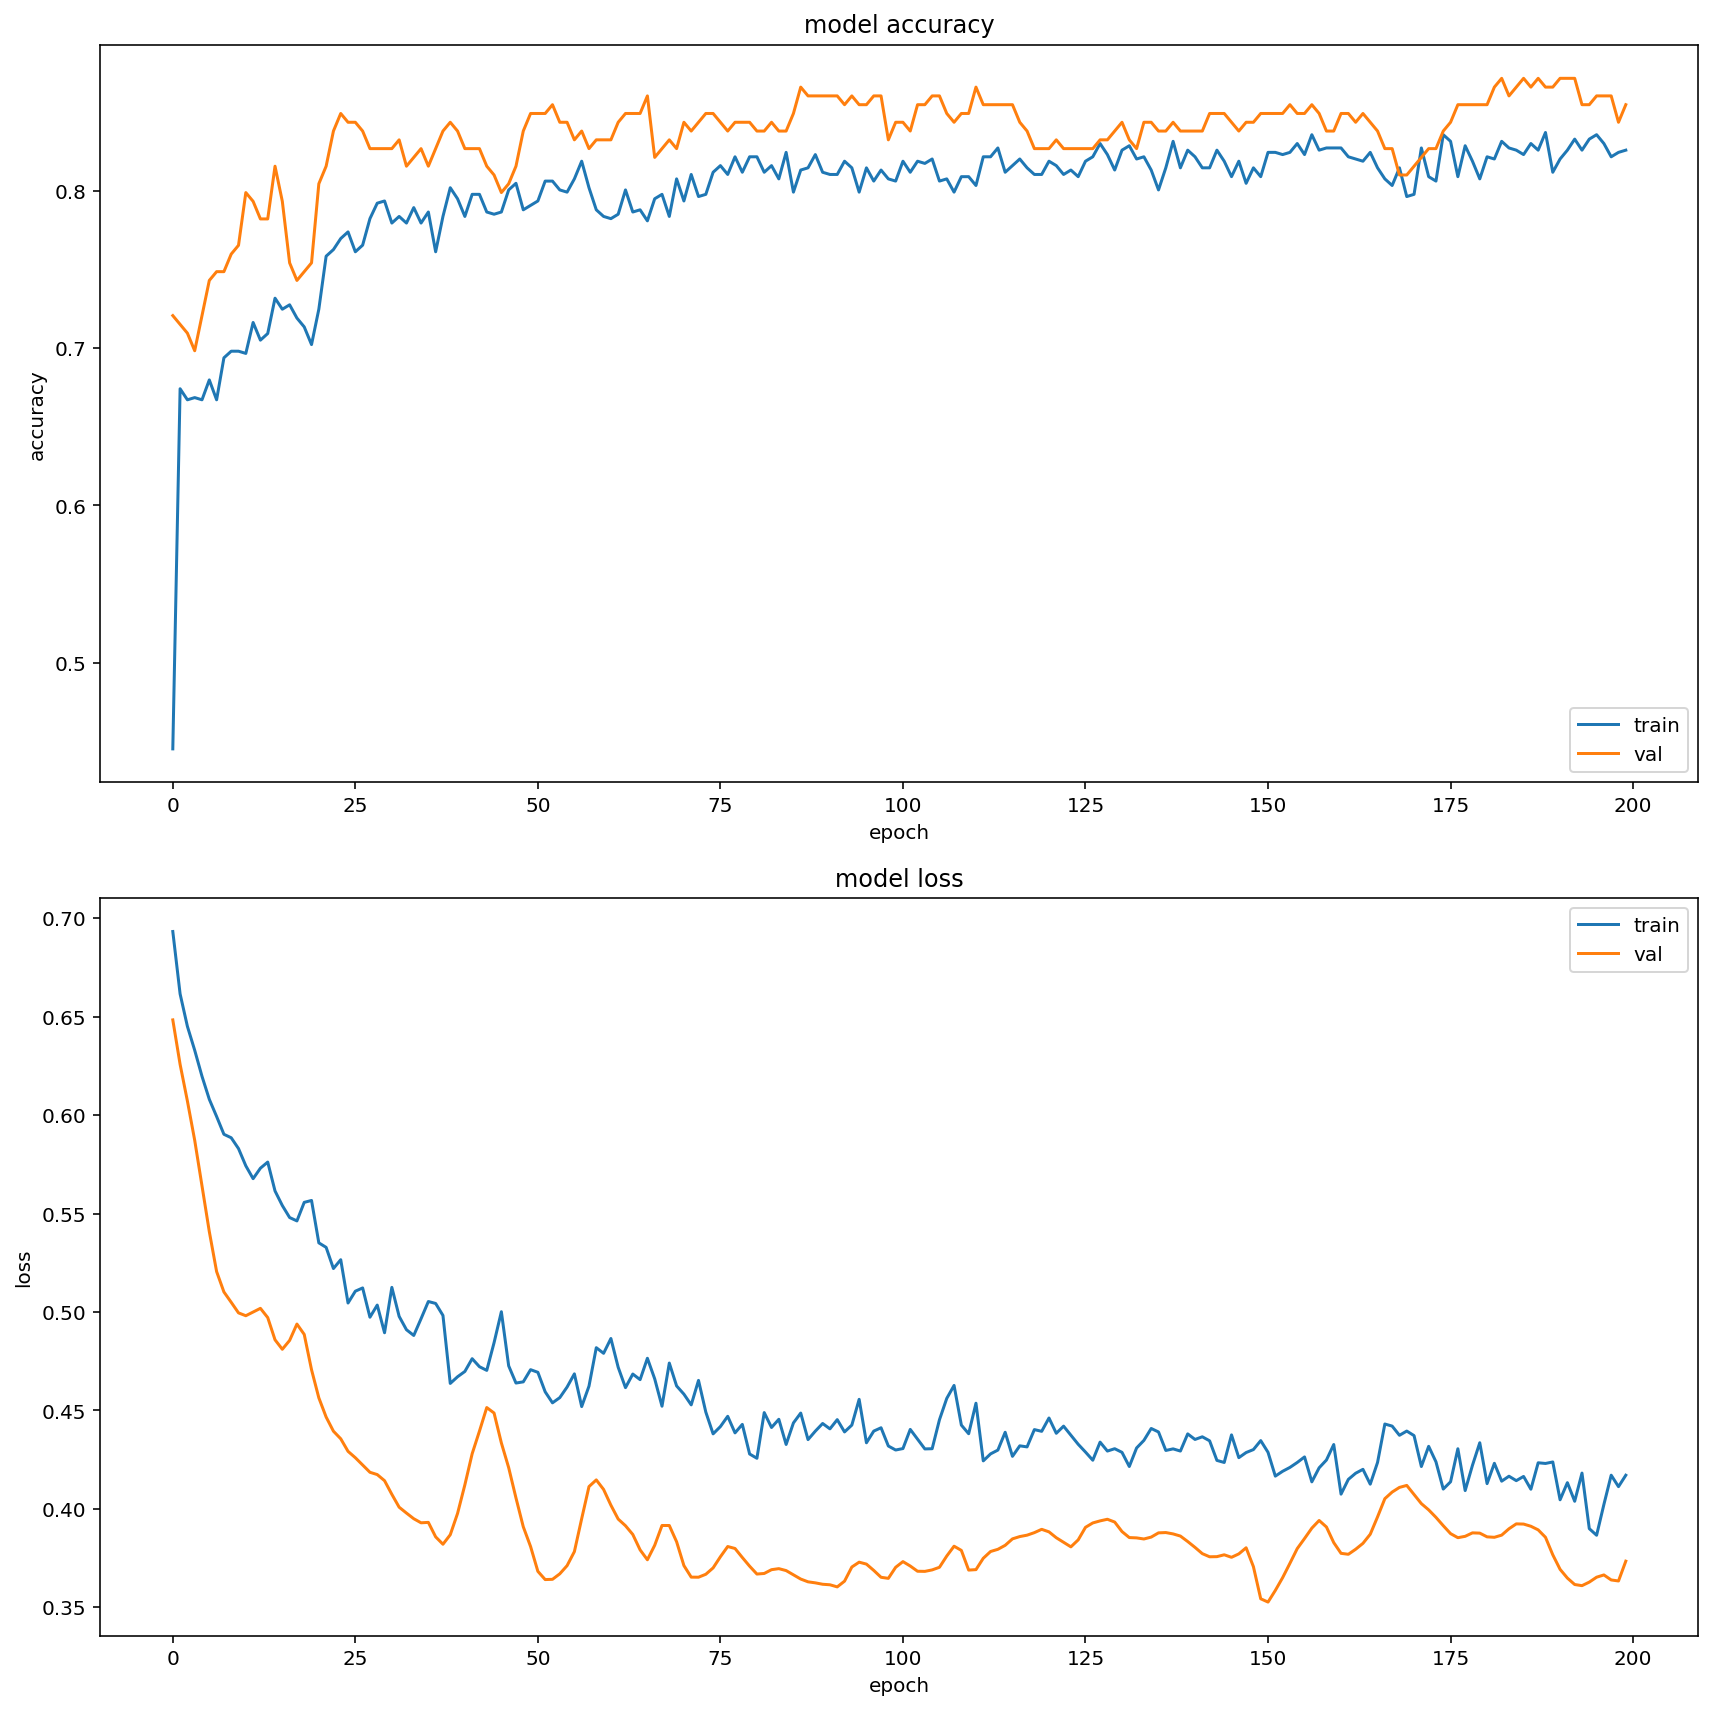

In [120]:
# plotting the metrics
fig = plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()

plt.show()

### [1 MARK] Which feature set is/are found to be best predicting the target variable? What is the best performance that you observe?


`Pclass`, `Sex`, `SibSp`, `Parch`, `Family_Size`, `Fare`, `Age`, `Embarked`, `Deck` are best at predicting target varibles. Best performance obeseved was 0.8939

### [1 MARK] What are the different network architectures that you tried out, and what are their performances? Put down this in a table below listing the number of hidden layers, the number of neurons/nodes in each of these layer, and their corresponding performances. 

```
20->relu->20->relu->100->relu->50->softmax->2 :
loss: 0.4222 - binary_accuracy: 0.8244 - val_loss: 0.3363 - val_binary_accuracy: 0.8659

20->relu->20->relu->100->relu->50->softmax->2 :
loss: 0.3790 - binary_accuracy: 0.8469 - val_loss: 0.3454 - val_binary_accuracy: 0.8771

20->relu->20->relu->100->relu->200->relu->100->relu->50->softmax->2 :
loss: 0.3368 - binary_accuracy: 0.8652 - val_loss: 0.3253 - val_binary_accuracy: 0.8939 (epoch=200)

20->relu->100->relu->300->relu->512->relu->256->relu->128->softmax->2 :
loss: 0.3152 - binary_accuracy: 0.8792 - val_loss: 0.4219 - val_binary_accuracy: 0.8324 (epoch=200)

20->relu->128->relu->128->relu->256->relu->256->relu->512->relu->128->relu->64->softmax->2 :
loss: 0.3000 - binary_accuracy: 0.8778 - val_loss: 0.3893 - val_binary_accuracy: 0.8380 (epoch=200)

20->relu->128->relu->128->relu->512->relu->512->relu->1024->relu->256->relu->64->softmax->2 :
loss: 0.3851 - binary_accuracy: 0.8497 - val_loss: 0.3935 - val_binary_accuracy: 0.8827 (epoch=160)
```

### [1 MARK] Which is the ANN network architecture that performed the best?
`20->relu->20->relu->100->relu->200->relu->100->relu->50->softmax->2` trained for `epochs=200` `with batch_size=700` performed best with `validation accuracy of 89%`

##  [2 MARKS] What are the new things that you learned by doing this assignment. List down at least 3 bullet points. 

1. Adding dropout layers can reduce overfitting
2. Removing `NaN` values from data set is essential for training. This can be either down by `dropna()` or replacing with mean
3. Higher epoch can lead to overfitting
4. Learned to plot and interpret `seaborn.catplot()`
